## Outline:
1. Explore dataset
    - Missing or null values
    - Distributions
    - Summary statistics
3. Multicollinearity
    - Correlation matrix
    - VIF
4. Categorical variable - encoding
5. Outlier analysis
5. Model building
    - Split dataset into train and test set
    - Define and fit the model
    - Explore relationship
        - Different variables
        - Interaction terms?
    - Model summary
        - Summary statistics
        - F-statistic
    - Model adequacy checking
        - Residual plots
            - Residuals vs fitted values plot - externally studenized residuals
            - Normal probability plot
    - Outliers
    - Collinearity check
10. Define final regression equation
    - Which may be the best model?
14. Conclusion

---

Check out the dataset on Kaggle: https://www.kaggle.com/datasets/aungpyaeap/fish-market

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

#### Styles

In [3]:
sns.set_theme(style='darkgrid')

In [6]:
df = pd.read_csv(r'C:\Users\chris\OneDrive\Documents\Personal Projects\Fish\Fish.csv')

# 1. Explore the dataset

In [7]:
print(df.columns)
print(df.shape)

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height',
       'Width'],
      dtype='object')
(159, 7)


#### Column descriptions
Weight - weight of fish in grams <br>
Length1 - vertical length in cm<br>
Length2 - Diagonal length in cm<br>
Length3 - Cross length in cm<br>
Height - height in cm<br>
Width - Diagonal width in cm

In [8]:
df = df.rename({'Length1':'Vertical_Length', 'Length2':'Diagonal_Length', 'Length3':'Cross_Length'}, axis='columns')

In [9]:
# separate into category and numerical columns
df_cat = df[['Species']]
df_num = df.select_dtypes(include='number')

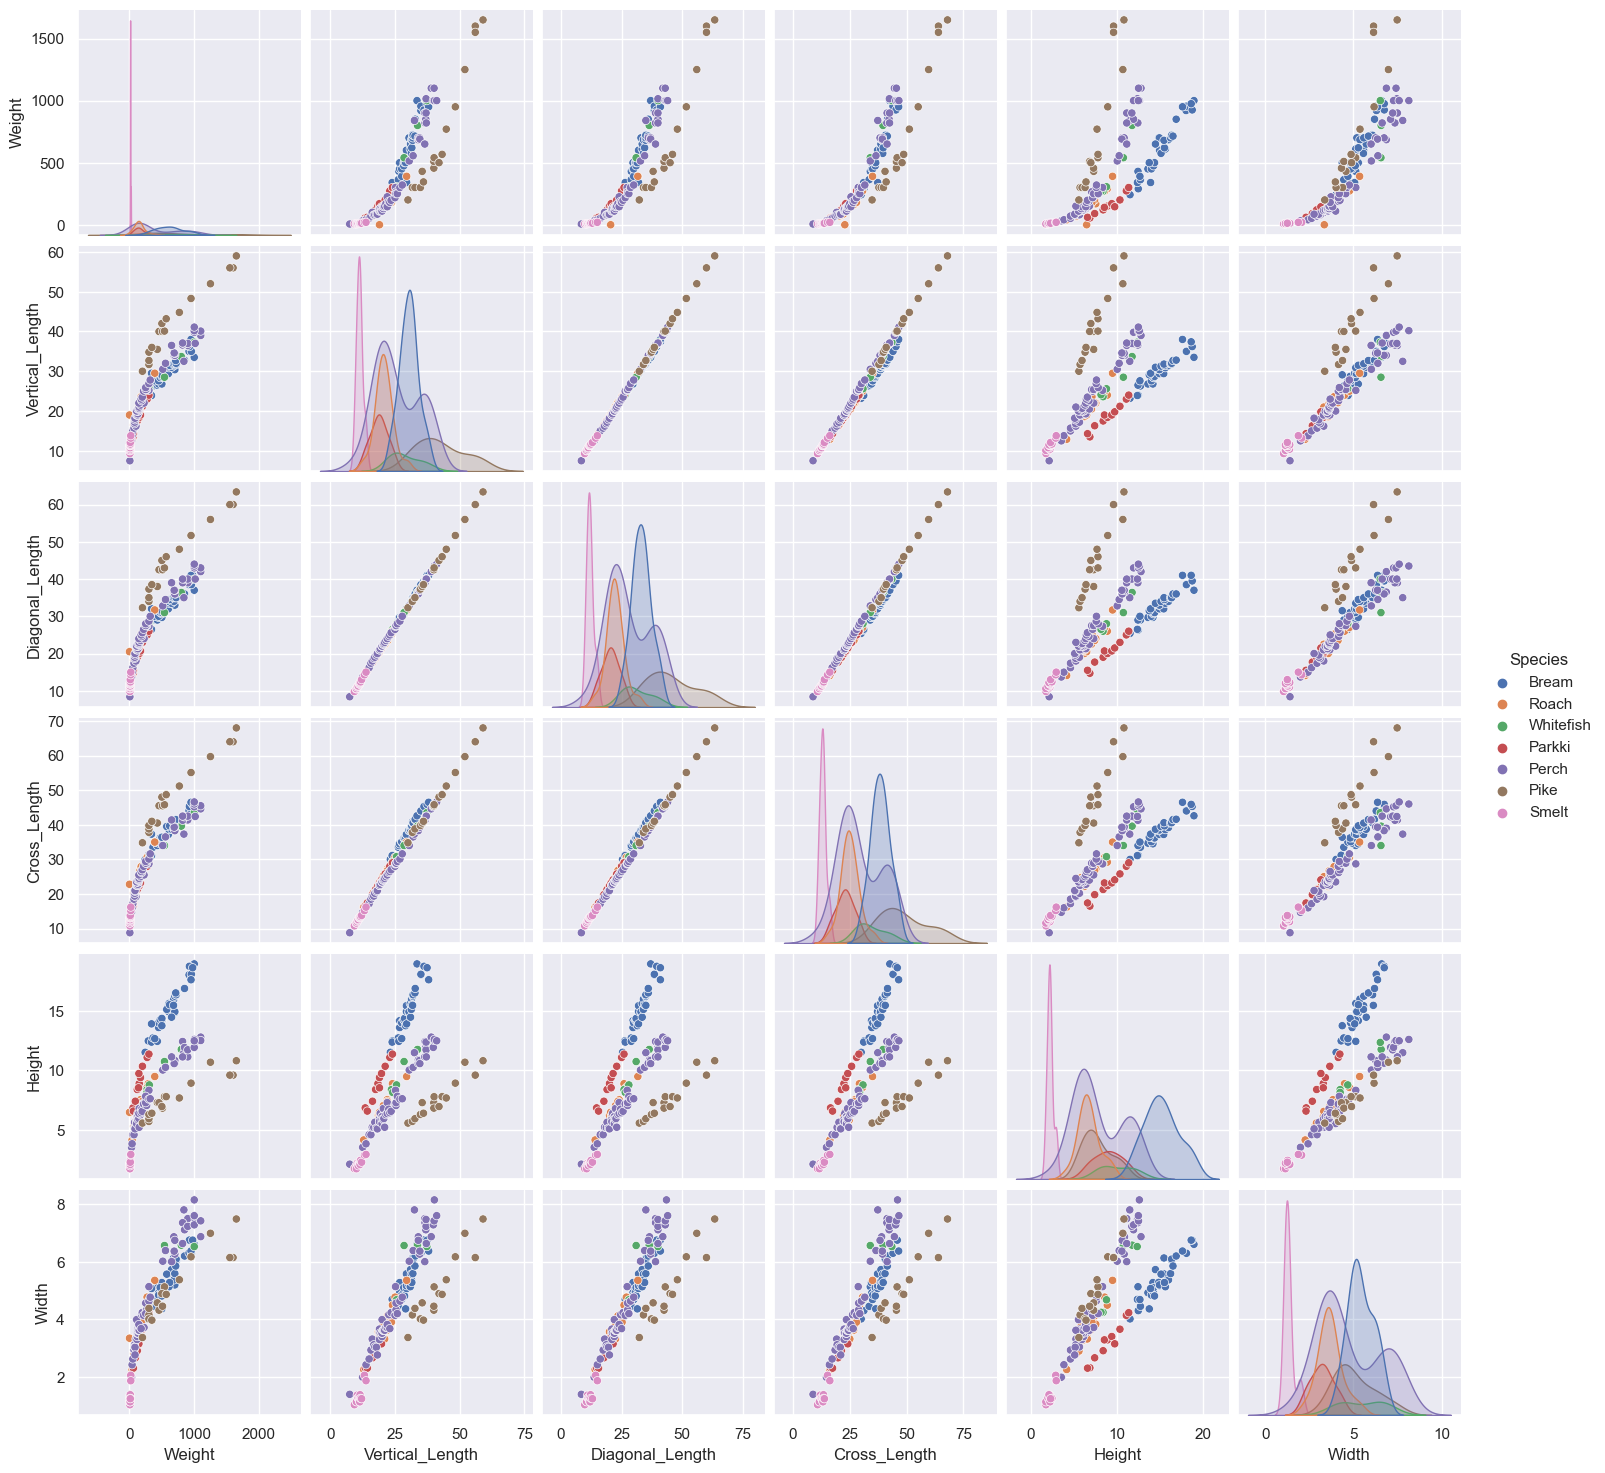

In [10]:
sns.pairplot(df, kind="scatter", hue='Species')
plt.show()

This **correlogram** (Scatter pplot matrix) allows us to see that a linear relationship may be appropriate for this dataset (although it does appear that a nonlinear model might be better), but for the sake of this example, we will continue with the linear assumption.<br>
Any regression model that is linear in the parameters is a linear regression model, regardless of the shape that it may generate (Cite: Montgomery textbook).

This means that the weight of a fish ($y$) can be computed using a linear combination of its different length measurements given the function:<br>
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5
$$

with $\beta_0$ representing the constant term.<br>
Now, we will learn the best values for our $\beta$s from the data, which is where the process for training the model begins. A trained model is a model where the $\beta$ values have been decided. A model with this parameters pre built into the formula is what constitutes a parameteric model. In other words, we fix the formula of the training function before the training.

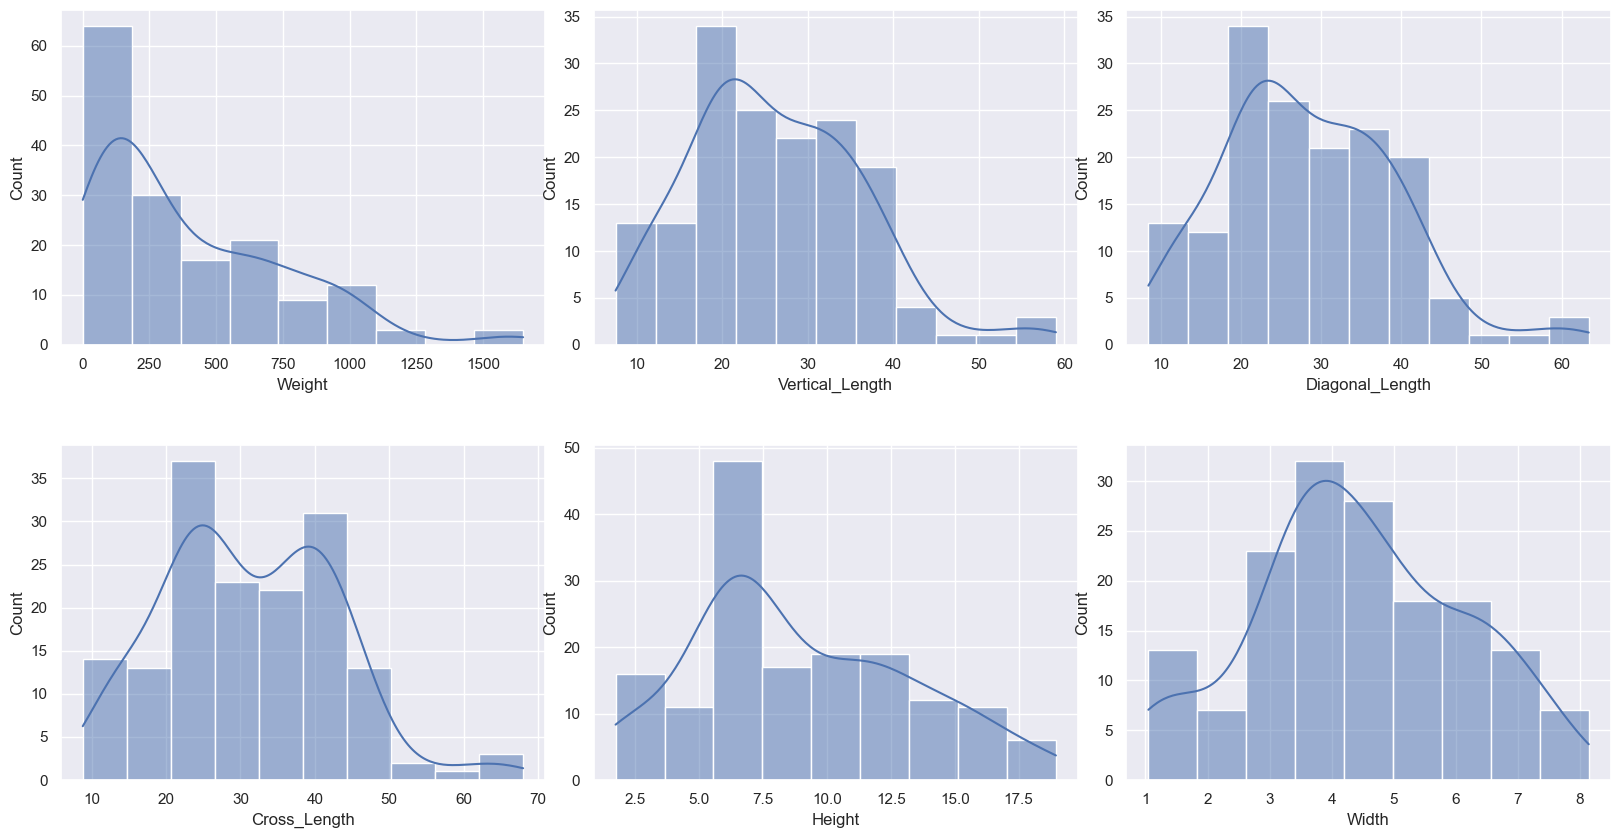

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

axes = axes.ravel()

for i, col in enumerate(df_num):
    sns.histplot(data = df[col], ax=axes[i], kde=True)
plt.show()

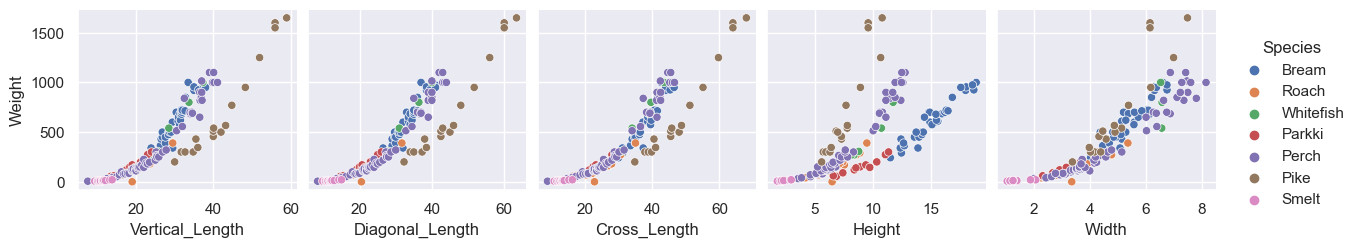

In [14]:
sns.pairplot(df, 
             x_vars=['Vertical_Length', 'Diagonal_Length', 'Cross_Length', 'Height', 'Width'],
             y_vars=['Weight'], hue='Species')
plt.show()

In [17]:
null_sum = df.isna().sum()
print(null_sum)

Species            0
Weight             0
Vertical_Length    0
Diagonal_Length    0
Cross_Length       0
Height             0
Width              0
dtype: int64


**Summary Statistics**

In [18]:
print(len(df))
df.describe()

159


,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


**Notes**
- Notice there are some values where the weight is equal to zero, which is impossible, so it may be an input error and could possibly remove those values
- I should maybe explore each category of species to see if any might be out of the ordinary there

In [19]:
species = df['Species'].value_counts()
species

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [20]:
# Weight cannot be 0g, so should look at those values
zeros = df[df['Weight'] == 0]
zeros

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


This fish cannot possibly weigh 0g, so we will assume for our example that maybe the value was input in error, and will delete this row

In [21]:
# high values - Pike
df[142:145]

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
142,Pike,1600.0,56.0,60.0,64.0,9.600,6.144
143,Pike,1550.0,56.0,60.0,64.0,9.600,6.144
144,Pike,1650.0,59.0,63.4,68.0,10.812,7.480


These values seem pretty high compared to the rest of the Pike weights, but I have no way to investigate if the data were entered incorrectly, or some other error occurred, so we will assume they are valid data and keep them in the model, until we do further outlier analysis.

In [22]:
# new df with bad value removed and view summary statistics
df1 = df[df['Weight'] != 0]
df1.describe()

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,400.847468,26.293038,28.465823,31.280380,8.986790,4.424232
std,357.697796,10.011427,10.731707,11.627605,4.295191,1.689010
min,5.900000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,121.250000,19.150000,21.000000,23.200000,5.940600,3.398650
50%,281.500000,25.300000,27.400000,29.700000,7.789000,4.277050
75%,650.000000,32.700000,35.750000,39.675000,12.371850,5.586750
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


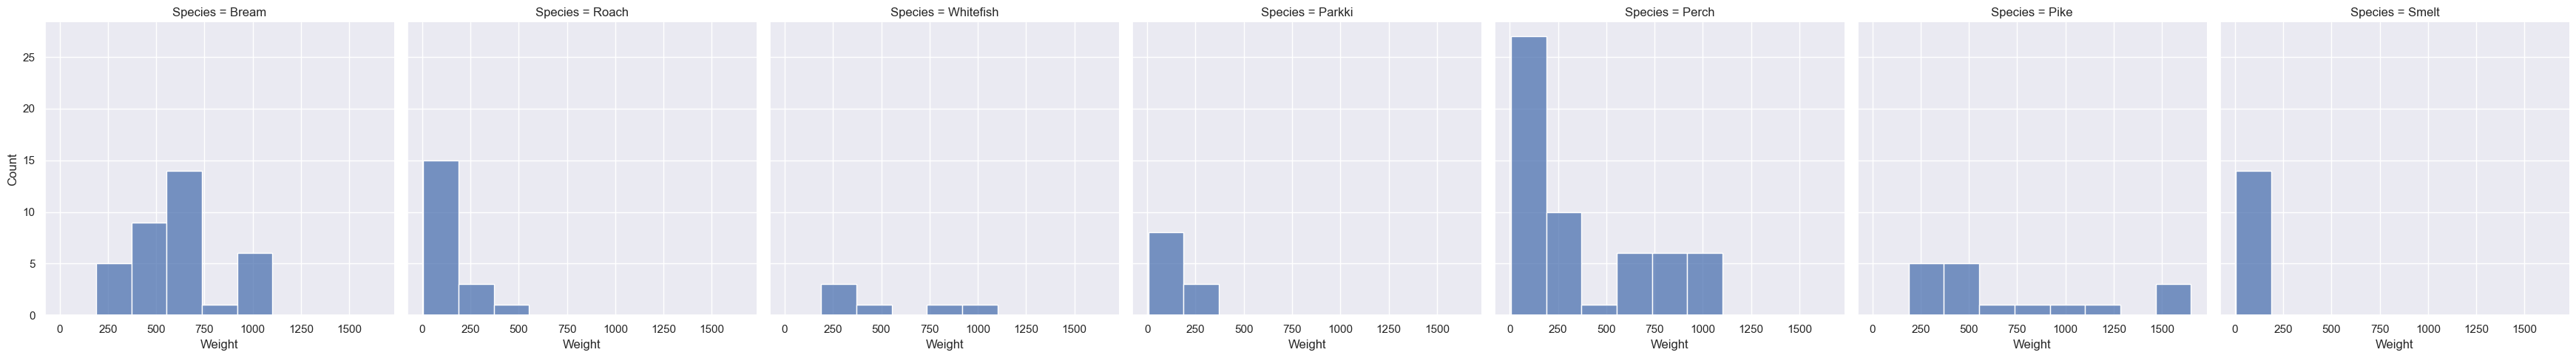

In [28]:
# trying a view of the counts by species for weight
sns.displot(
    data=df1,
    x='Weight',
    col='Species',
    kind='hist')
plt.show()

# 2. Multicollinearity

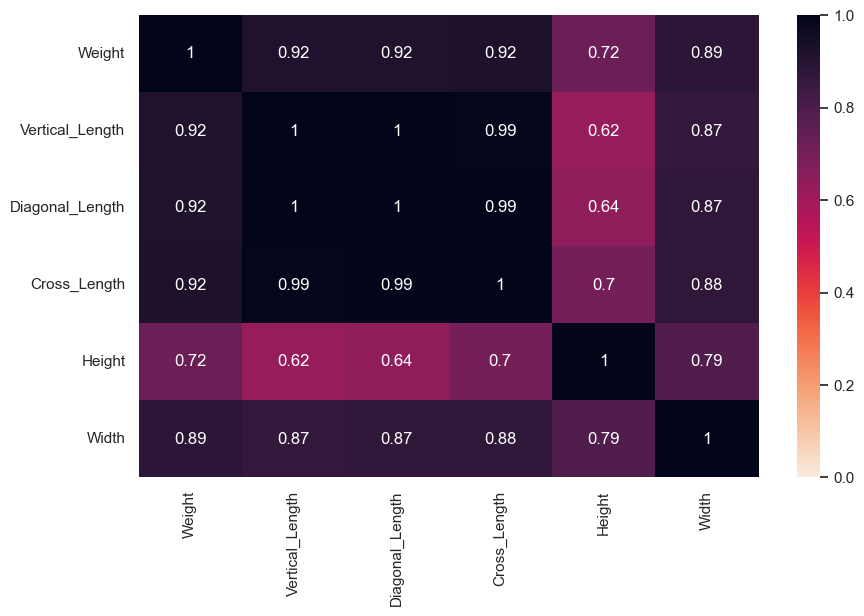

In [27]:
# make figure a bit bigger
plt.figure(figsize=(10,6))

# correlation heatmap
sns.heatmap(df1.corr(), annot=True, vmin=0, vmax=1, cmap="rocket_r")
plt.show()

- Note that all are pretty highly correlated, especially the length variables, height has the least issues with this

In [29]:
# VIF
df1_num = df1.select_dtypes(include='number')
df1_vif = df1_num.drop(columns=['Weight'])

vif_data = pd.DataFrame()

vif_data['Column'] = df1_vif.columns

vif_data['VIF'] = [vif(df1_vif.values, i) for i in range(len(df1_vif.columns))]

vif_data.sort_values(by='VIF', ascending=True)

,Column,VIF
3,Height,76.053658
4,Width,92.653797
2,Cross_Length,3382.291295
0,Vertical_Length,12749.616323
1,Diagonal_Length,16580.478064


- All of these have a very high VIF if using the rule of thumb;
    - 1 = not correlated
    - Between 1 and 5 = moderately correlated
    - Greater than 5 = highly correlated
- Clearly these are very large, which indicates high multicollinearity
- Although how large is subjective, and these VIF values may not be a cause for concern because of nonlinearity

# 3. Categorical variables

In [30]:
# categorical encoding
df2 = pd.get_dummies(df1)
df2

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,0,1,0
155,13.4,11.7,12.4,13.5,2.4300,1.2690,0,0,0,0,0,1,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,0,1,0
157,19.7,13.2,14.3,15.2,2.8728,2.0672,0,0,0,0,0,1,0


# 4. Outlier analysis

In [33]:
# separate into category and numerical columns
df1_cat = df1[['Species']]
df1_num = df1.select_dtypes(include='number')

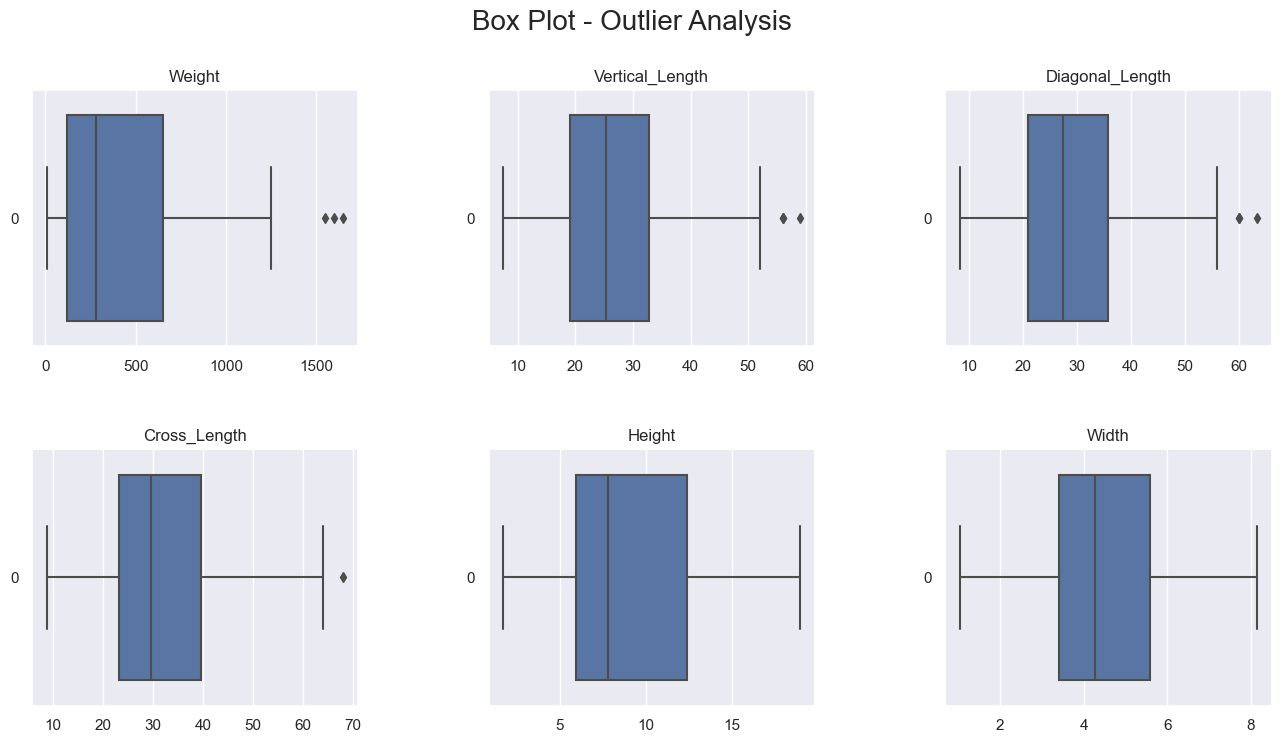

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.suptitle('Box Plot - Outlier Analysis', fontsize=20)

for i, col in enumerate(df1_num):
    box=sns.boxplot(data=df1_num[col], ax=axes[i], orient='h')
    axes[i].set_title(col)
    
plt.show()

Note: It seems there are three values that might be a cause for concern, so we will fit the model with and without them, and compare results

# 5. Model building
- Then we will fit the full model to use for comparison when we explore further
    - SKLearn
    - Statsmodels

## Split into training and test sets

In [129]:
# we will split using the data frame with the dummy variables
# Note: this data frame is the full data frame - no variables or outliers yet removed
X = df2.iloc[:, 1:13]
y = df2[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [130]:
print('X_train: ', np.shape(X_train))
print('y_train: ', np.shape(y_train))

X_train:  (118, 12)
y_train:  (118, 1)


## Define and fit the model

In [49]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [50]:
# Parameters of the model
print('Model intercept: ', model.intercept_)
print('Model coefficients: ', model.coef_)
print('Model score: ', model.score(X, y))

Model intercept:  [-759.29101839]
Model coefficients:  [[ -63.17797578   71.70850333   27.81978955  -11.52939024    6.42359181
   -26.38461117  107.38170507    8.00260057 -388.96543855  -16.91968605
   280.06469614   36.82073399]]
Model score:  0.9329499697782534


In [51]:
# predicting weights from the test set
y_hat = model.predict(X_test)

In [52]:
# Analyzing success of model from training set and predictions
# r2_score(y_train, y_hat)    # 0.92899
r2_score(y_test, y_hat)

0.9482451798572475

In [53]:
cross_val_score_train = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(cross_val_score_train)

[0.91333352 0.96324695 0.93654314 0.9341261  0.86007924 0.9247442
 0.82266236 0.88844178 0.84039499 0.60139132]


In [54]:
cross_val_score_train.mean()

0.8684963615355723

In [55]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 6790.893
RMSE: 82.407
MAE: 7.909


In [34]:
# using the original model (full), I will look at the statsmodels package results

## Summary

In [56]:
X_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     122.8
Date:                Sun, 05 Feb 2023   Prob (F-statistic):           4.74e-55
Time:                        14:36:48   Log-Likelihood:                -705.36
No. Observations:                 118   AIC:                             1435.
Df Residuals:                     106   BIC:                             1468.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -664.3796     56.392    -11.782      0.000    -776.182    -552.578
Vertical_Length     -63.1780     46.329     -1.364      0.176    -155.030      28.674
Diagonal_Length      71.7085     57.073      1.256      0.212     -41.444     184.861
Cross_Length         27.8198     36.164      0.769      0.443     -43.879      99.519
Height              -11.5294     17.413     -0.662      0.509     -46.051      22.993
Width                 6.4236     30.262      0.212      0.832     -53.575      66.422
Species_Bream      -121.2960    117.392     -1.033      0.304    -354.036     111.444
Species_Parkki       12.4703     53.338      0.234      0.816     -93.277     118.218
Species_Perch       -86.9088     46.430     -1.872      0.064    -178.960       5.143
Species_Pike       -483.8768     86.341     -5.604      0.000    -655.056    -312.698
Species_Roach      -111.8311     30.069     -3.719      0.000    -171.445     -52.217
Species_Smelt       185.1533     49.995      3.703      0.000      86.034     284.273
Species_Whitefish   -58.0906     51.449     -1.129      0.261    -160.093      43.912
==============================================================================
Omnibus:                       24.525   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.917
Skew:                           0.953   Prob(JB):                     2.15e-09
Kurtosis:                       5.118   Cond. No.                     9.37e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.86e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Residual Analysis

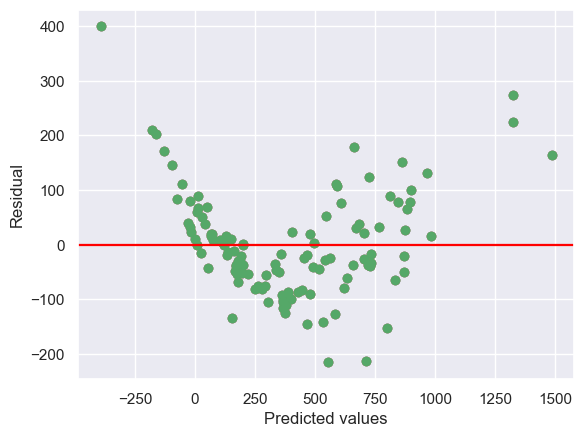

In [59]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

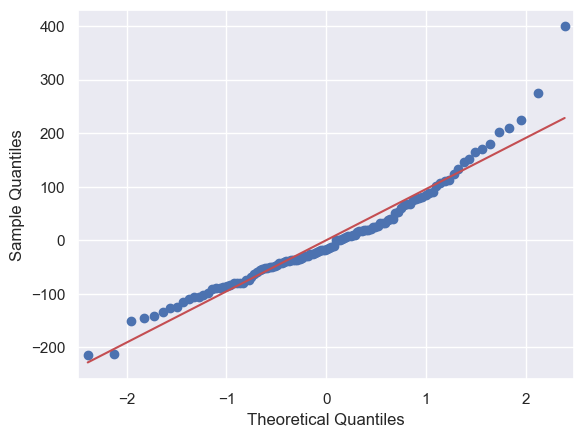

In [60]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Clearly, it mostly follows the line except for three points at the top, which one may or may not remove, depending on preference

## Outliers

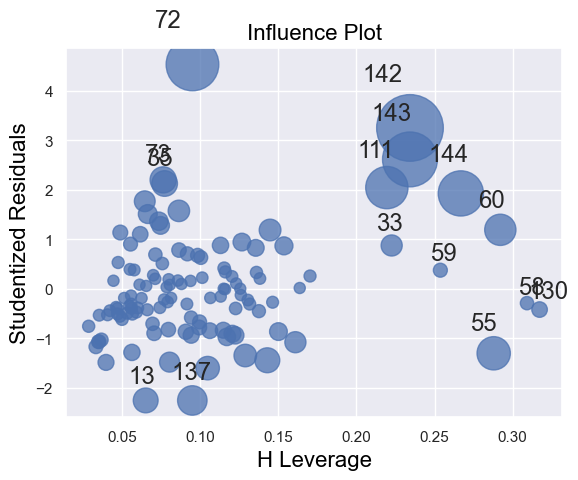

In [63]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')
plt.show()

In [66]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(X_train)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X_train.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.03389830508474576
Int64Index([137, 142, 111, 143, 144, 60, 55, 72], dtype='int64') 
 [0.03934488 0.22826771 0.08799532 0.1526742  0.10164022 0.04513298
 0.05214074 0.14003056]


Clearly, there are some points that seem to have a high amount of leverage or influence

# 6. Explore relationships
- Test with different variables
- Test with possible interaction terms


---

| Model  | $R^2$ | Adj. $R^2$ | F-Statistic | RMSE | Notes |
| ------ | ----- | ---------- | ----------- | ---- | :--- |
| Full | 0.936 | 0.931 | 193.6 | 90.652| Lots of issues with the variables |
| Vertical Length | 0.93 | 0.927 | 220.9 | 90.652 | Width and height p values are still high |
| Diagonal Length | 0.933 | 0.929 | 230.0 | 87.159 | Same |
| Cross Length | 0.934 | 0.930 | 231.6 | 87.144 | Same |
| Int - Vertical | 0.973 | 0.971 | 526.4 | 63.345 | Good p values if a = 0.05, residuals look better than full |
| Int - Diagonal | 0.973 | 0.971 | 529.1 | 63.318 | Same |
| Int - Cross | 0.973 | 0.971 | 528.7 | 62.310 | High p-value for width |
| ln(y) | 0.99 | 0.99 | Good | 0.088 | Good p values for everything |

In [67]:
# do again, but with only one length column
X = df2.drop(columns=['Weight', 'Vertical_Length', 'Diagonal_Length'])
y = df2[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [69]:
y_hat = lr.predict(X_test)

In [70]:
r2_score(y_test, y_hat)
# Cross length - 0.9434291295580692
# Vert - 0.9387835896394756
# diag - 0.9387835896394756

0.9434291295580692

In [71]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 7594.113
RMSE: 87.144
MAE: 8.016


In [72]:
# testing with different parameters - interaction terms
# vert - 0.973, 0.971, f 526.4
# cross - f 528.7, issues with p value of width
# diag - f 529.1, issues with width
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     231.6
Date:                Sun, 05 Feb 2023   Prob (F-statistic):           1.63e-82
Time:                        14:39:19   Log-Likelihood:                -938.31
No. Observations:                 158   AIC:                             1897.
Df Residuals:                     148   BIC:                             1927.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -684.6471     33.366    -20.519      0.000    -750.582    -618.712
Cross_Length         36.1375      3.621      9.980      0.000      28.982      43.293
Height                9.0784     13.107      0.693      0.490     -16.822      34.979
Width                -4.6968     24.060     -0.195      0.845     -52.242      42.849
Species_Bream      -195.8982     64.292     -3.047      0.003    -322.947     -68.850
Species_Parkki      -50.3780     41.783     -1.206      0.230    -132.946      32.190
Species_Perch       -50.8339     22.853     -2.224      0.028     -95.995      -5.673
Species_Pike       -403.3187     70.404     -5.729      0.000    -542.446    -264.191
Species_Roach      -105.4074     22.473     -4.690      0.000    -149.818     -60.997
Species_Smelt       210.9845     31.995      6.594      0.000     147.758     274.211
Species_Whitefish   -89.7954     37.319     -2.406      0.017    -163.542     -16.049
==============================================================================
Omnibus:                       40.058   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.675
Skew:                           1.112   Prob(JB):                     2.49e-19
Kurtosis:                       5.840   Cond. No.                     4.12e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Interaction terms

In [73]:
df2['Volume'] = df2['Height']*df2['Width']*df2['Vertical_Length']

In [74]:
X = df2.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df2[['Weight']]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9701085869761379
Adj r2:  0.9536683098130138
MSE: 4012.644
RMSE: 63.345
MAE: 6.850


In [77]:
# testing with different parameters - interaction terms
# vert - 0.973, 0.971, f 526.4
# cross - f 528.7, issues with p value of width
# diag - f 529.1, issues with width
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     389.7
Date:                Sun, 05 Feb 2023   Prob (F-statistic):           9.50e-84
Time:                        14:40:30   Log-Likelihood:                -694.20
No. Observations:                 126   AIC:                             1410.
Df Residuals:                     115   BIC:                             1442.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -51.9033     45.659     -1.137      0.258    -142.346      38.539
Vertical_Length      28.2106      3.024      9.330      0.000      22.221      34.200
Height              -68.0829     11.267     -6.043      0.000     -90.400     -45.766
Width               -10.7703     18.289     -0.589      0.557     -46.997      25.456
Species_Bream       214.3637     54.828      3.910      0.000     105.760     322.967
Species_Parkki      170.2363     34.332      4.959      0.000     102.232     238.241
Species_Perch       -50.2534     17.367     -2.894      0.005     -84.654     -15.853
Species_Pike       -333.3482     53.258     -6.259      0.000    -438.841    -227.855
Species_Roach       -26.7588     17.402     -1.538      0.127     -61.229       7.711
Species_Smelt       -99.6955     30.442     -3.275      0.001    -159.995     -39.396
Species_Whitefish    73.5525     29.122      2.526      0.013      15.868     131.237
Volume                0.2604      0.019     13.661      0.000       0.223       0.298
==============================================================================
Omnibus:                       27.330   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.453
Skew:                           0.641   Prob(JB):                     2.08e-23
Kurtosis:                       7.272   Cond. No.                     3.47e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.57e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

> Lets use the interaction term with vertical length for residual analysis

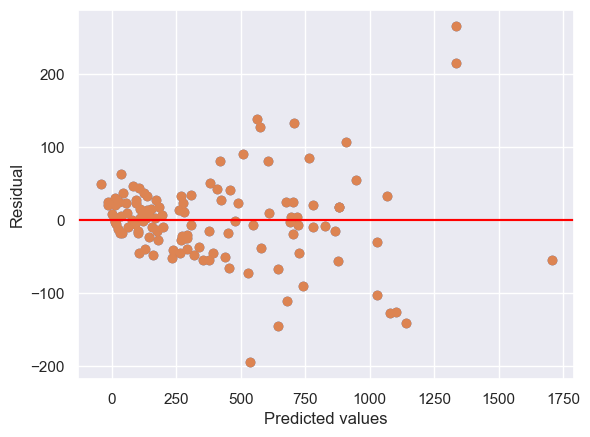

In [79]:
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

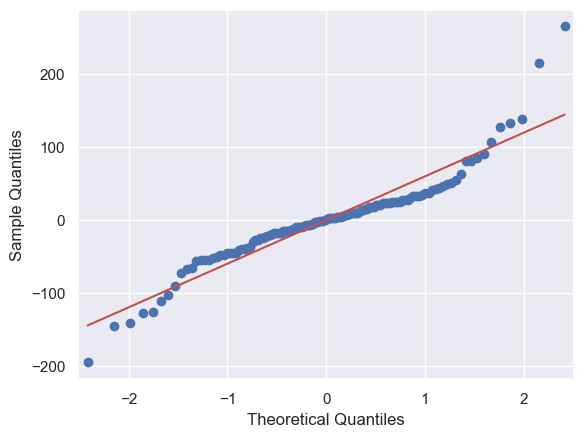

In [80]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Still some questionable points at the top, but the rest is close to the line

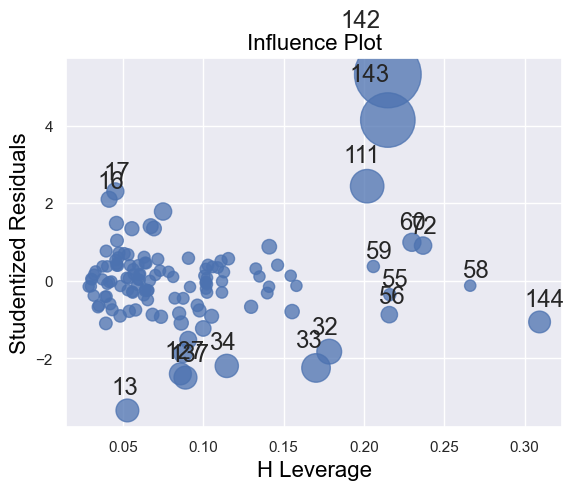

In [83]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')
plt.show()

In [85]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.031746031746031744
Int64Index([127, 137, 142, 32, 33, 111, 34, 143, 144, 13], dtype='int64') 
 [0.04319052 0.048439   0.52110123 0.05914018 0.08327766 0.12015573
 0.05026027 0.34302449 0.04196964 0.04766423]


In [86]:
# outlier removal and variable selection
df3 = df2.drop([142, 143, 144])
len(df3)

155

In [87]:
X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9858885592047286
Adj r2:  0.9777187776916768
MSE: 1577.113
RMSE: 39.713
MAE: 5.347


In [88]:
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     504.5
Date:                Sun, 05 Feb 2023   Prob (F-statistic):           8.13e-89
Time:                        14:42:19   Log-Likelihood:                -651.73
No. Observations:                 124   AIC:                             1325.
Df Residuals:                     113   BIC:                             1356.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -87.0666     36.202     -2.405      0.018    -158.789     -15.345
Vertical_Length      13.3725      2.944      4.542      0.000       7.540      19.205
Height              -26.3130     10.191     -2.582      0.011     -46.502      -6.124
Width                12.2972     14.252      0.863      0.390     -15.938      40.532
Species_Bream        24.7492     48.458      0.511      0.611     -71.255     120.753
Species_Parkki       51.7058     30.574      1.691      0.094      -8.867     112.278
Species_Perch       -28.0813     13.627     -2.061      0.042     -55.079      -1.083
Species_Pike       -123.8397     48.710     -2.542      0.012    -220.343     -27.336
Species_Roach       -26.9641     13.364     -2.018      0.046     -53.440      -0.488
Species_Smelt       -18.1338     25.604     -0.708      0.480     -68.860      32.592
Species_Whitefish    33.4972     21.490      1.559      0.122      -9.079      76.073
Volume                0.2296      0.016     14.556      0.000       0.198       0.261
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   2.297
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.782
Skew:                          -0.078   Prob(JB):                     3.84e-14
Kurtosis:                       6.455   Cond. No.                     2.34e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.26e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

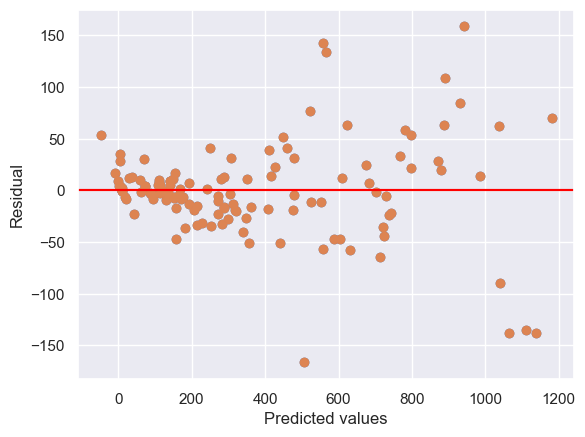

In [90]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

 From the residual plot, it looks as though it is random for high values, but not random for lower values. The mean is around 400, above the mean it looks random, and below, not so much

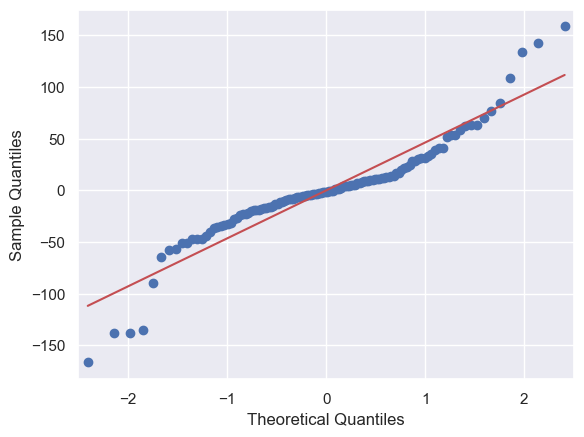

In [91]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Clearly, it mostly follows the line except for a few in the tails

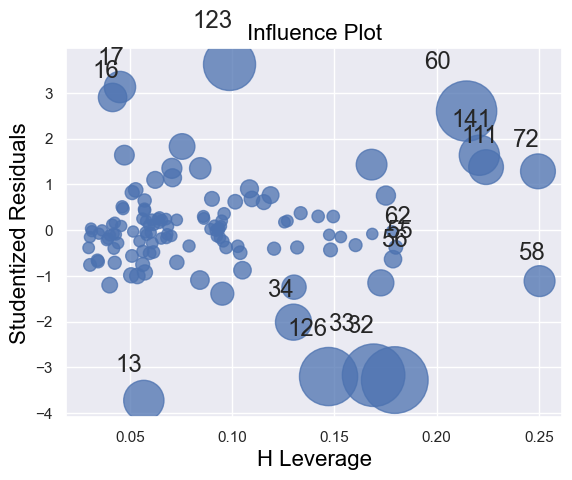

In [94]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')
plt.show()

In [95]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.03225806451612903
Int64Index([123, 32, 111, 33, 126, 34, 140, 141, 13, 60, 17, 58, 72], dtype='int64') 
 [0.10809361 0.18047427 0.04522624 0.15816001 0.13628512 0.04914922
 0.03417223 0.0622776  0.06255856 0.14659308 0.03578017 0.03457244
 0.04543388]


eval_env: 1


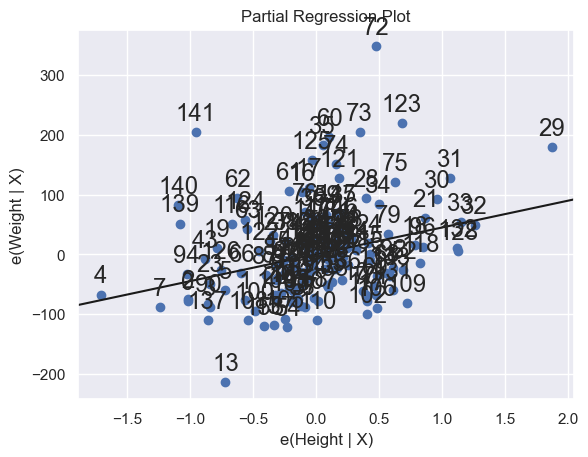

In [96]:
sm.graphics.plot_partregress(
    endog='Weight',
    exog_i = 'Height',
    exog_others=['Width', 'Vertical_Length', 'Diagonal_Length', 'Cross_Length', 'Species_Bream', 'Species_Parkki', 'Species_Perch', 'Species_Pike', 'Species_Roach', 'Species_Whitefish', 'Species_Smelt'],
    data=df3,
    obs_labels=True)
plt.show()

**Partial Regression plot** - a type of diagnostic plot for multilinear regression models, they attempt to show the effect of adding a new variable to an existing model by controlling for the effect of the predictors already in use. They are useful for spotting leverage and influential points.


---

With the funnel shape of the residuals, and the nonlinearity of the response variable, we performed the interaction term, but we may need to do a transformation to make it more linear. I will apply a log transformation of the response variable.<br>

**Log transform**

In [107]:
y = np.log(df3.Weight)

In [108]:
X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
ln_y = y

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, ln_y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9926637216147833
Adj r2:  0.9884164025496579
MSE: 0.013
RMSE: 0.113
MAE: 0.302


In [116]:
X_sm = sm.add_constant(X)
sm_model = sm.OLS(ln_y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1772.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):          2.29e-145
Time:                        15:16:03   Log-Likelihood:                 112.30
No. Observations:                 155   AIC:                            -202.6
Df Residuals:                     144   BIC:                            -169.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8334      0.084      9.901      0.000       0.667       1.000
Vertical_Length       0.0753      0.006     11.954      0.000       0.063       0.088
Height                0.2226      0.021     10.811      0.000       0.182       0.263
Width                 0.3046      0.033      9.312      0.000       0.240       0.369
Species_Bream        -0.1607      0.100     -1.614      0.109      -0.357       0.036
Species_Parkki        0.0624      0.064      0.971      0.333      -0.065       0.189
Species_Perch         0.3191      0.030     10.739      0.000       0.260       0.378
Species_Pike          0.2160      0.101      2.130      0.035       0.016       0.417
Species_Roach         0.2909      0.031      9.281      0.000       0.229       0.353
Species_Smelt        -0.2002      0.056     -3.564      0.000      -0.311      -0.089
Species_Whitefish     0.3059      0.052      5.836      0.000       0.202       0.409
Volume               -0.0006   3.65e-05    -17.066      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      113.540   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1602.015
Skew:                          -2.392   Prob(JB):                         0.00
Kurtosis:                      18.005   Cond. No.                     1.12e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

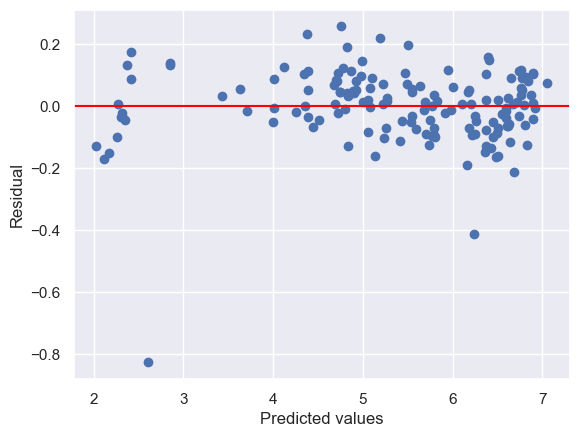

In [112]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

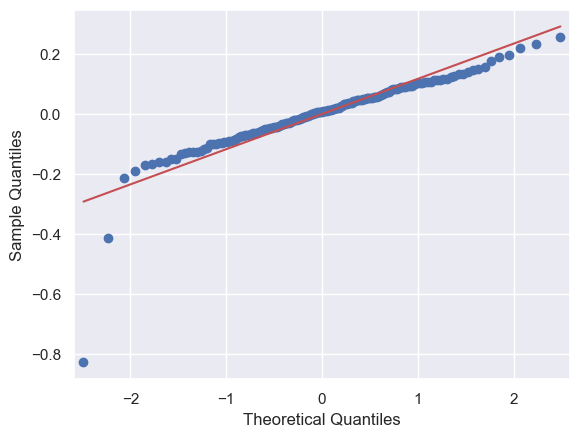

In [113]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

In [114]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.025806451612903226
Int64Index([13, 58, 72, 129], dtype='int64') 
 [0.04741908 0.04135149 1.30468698 0.03556287]


In [134]:
# remove point 13 and 72
# outlier removal and variable selection
df4 = df3.drop([13, 72])
len(df4)

153

In [135]:
y = np.log(df4.Weight)
X = df4.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
ln_y = y

X_train, X_test, y_train, y_test = train_test_split(X, ln_y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9889376169433561
Adj r2:  0.9825330793842465
MSE: 0.008
RMSE: 0.088
MAE: 0.272


In [143]:
# cross validation
import math
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
print(scores)
print('R2: ', np.mean(scores))

scores2 = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print(scores2)
print('RMSE: ', math.sqrt(np.mean(abs(scores2))))

[0.99328735 0.99616257 0.99699811 0.99280587 0.99479305]
R2:  0.9948093908684956
[-0.00890102 -0.00966734 -0.00552462 -0.01043415 -0.0089092 ]
RMSE:  0.09320549511923606


In [124]:
X_sm = sm.add_constant(X)
sm_model = sm.OLS(ln_y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3241.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):          3.16e-162
Time:                        15:18:03   Log-Likelihood:                 160.77
No. Observations:                 153   AIC:                            -299.5
Df Residuals:                     142   BIC:                            -266.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1378      0.067     16.890      0.000       1.005       1.271
Vertical_Length       0.0702      0.005     15.187      0.000       0.061       0.079
Height                0.1879      0.015     12.390      0.000       0.158       0.218
Width                 0.2908      0.024     12.280      0.000       0.244       0.338
Species_Bream         0.0191      0.074      0.259      0.796      -0.126       0.165
Species_Parkki        0.1455      0.047      3.100      0.002       0.053       0.238
Species_Perch         0.3588      0.022     16.324      0.000       0.315       0.402
Species_Pike          0.2692      0.074      3.627      0.000       0.123       0.416
Species_Roach         0.3157      0.023     13.836      0.000       0.271       0.361
Species_Smelt        -0.3551      0.043     -8.284      0.000      -0.440      -0.270
Species_Whitefish     0.3845      0.039      9.965      0.000       0.308       0.461
Volume               -0.0005   2.84e-05    -18.031      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   1.345
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.321
Skew:                           0.212   Prob(JB):                        0.517
Kurtosis:                       2.835   Cond. No.                     1.54e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.22e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

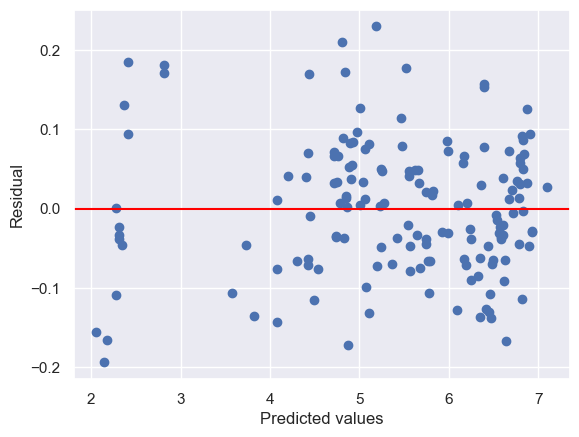

In [125]:
# using model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

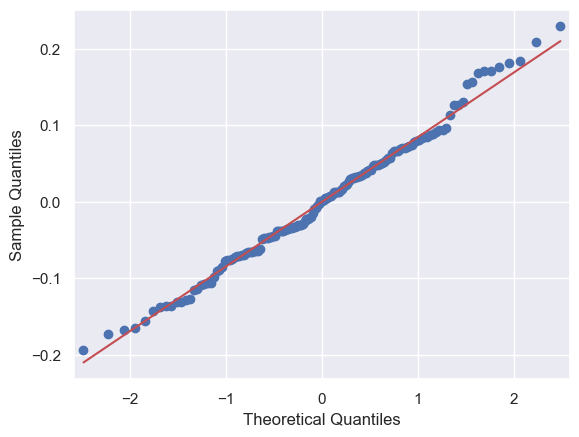

In [126]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

In [121]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.025974025974025976
Int64Index([13, 58, 60, 96, 129, 147, 155, 157, 158], dtype='int64') 
 [0.07533316 0.06515374 0.02668005 0.02895852 0.04525074 0.03119196
 0.02756269 0.03105461 0.03160339]


Based on these results, I will go back and also remove point 13

In [128]:
# Collinearity check
# VIF
df4 = df4.drop(columns=['Cross_Length', 'Diagonal_Length'])
df4_num = df4.select_dtypes(include='number')
df4_vif = df4_num.drop(columns=['Weight'])

vif_data = pd.DataFrame()

vif_data['Column'] = df4_vif.columns

vif_data['VIF'] = [vif(df4_vif.values, i) for i in range(len(df4_vif.columns))]

vif_data.sort_values(by='VIF', ascending=True)

,Column,VIF
8,Species_Smelt,3.669506
9,Species_Whitefish,6.484664
4,Species_Parkki,13.685896
7,Species_Roach,14.270406
6,Species_Pike,21.741758
10,Volume,24.329548
2,Width,30.745241
0,Vertical_Length,34.598043
5,Species_Perch,38.918315
3,Species_Bream,66.621419


These VIF values are much lower than before

## 6. Final model

---

The best looking model thus far is the model with the log transformation on the regressor variable, and taking out some influential/leverage points. This model had a low RMSE, and a high adjusted $R^2$, and good p-values for all the provided statistics.

#### Random Forest

In [132]:
# Random forest regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

# predictions
y_hat = rf.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-rf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9627550271655185
Adj r2:  0.946201705905749
MSE: 4887.016
RMSE: 69.907
MAE: 6.621


# 7. Conclusion

In [97]:
# now do some weight predictions with model
# length, height, width, bream, parkki, perch, pike, roach, smelt, whitefish, volume (Multiply first three numbers)

pred = lr.predict(np.array([[24.0, 12.0, 5.0, 1, 0, 0, 0, 0, 0, 0, 24*12*5]]))
print(pred)

[[334.98801576]]


C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
